In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.reset_default_graph()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pickle

training_data = pickle.load(open("data_set1.pickle", "rb"))

training_data = training_data/255.0

In [4]:
ruido_ph = tf.placeholder(tf.float32,[None, 100])

In [5]:
def gerador(ruido, reuse = None):
    with tf.variable_scope('gerador', reuse = reuse):
        #100 -> 128 -> 128 -> 784
        camada_oculta1 = tf.nn.relu(tf.layers.dense(inputs = ruido, units=1280))
        camada_oculta2 = tf.nn.relu(tf.layers.dense(inputs=camada_oculta1, units=1280))
        camada_saida = tf.layers.dense(inputs = camada_oculta2, units = 9216, activation = tf.nn.tanh)
        return camada_saida

In [6]:
imagens_reais_ph = tf.placeholder(tf.float32, [None, 9216])

In [7]:
def discriminador(X, reuse = None):
    with tf.variable_scope('discriminador', reuse = reuse):
        # 784 -> 128 -> 128 -> 1
        camada_oculta1 = tf.nn.relu(tf.layers.dense(inputs = X, units = 1280))
        camada_oculta2 = tf.nn.relu(tf.layers.dense(inputs = camada_oculta1, units = 1280))
        logits = tf.layers.dense(camada_oculta2, units=1)
        return logits

In [9]:
logits_imagens_reais = discriminador(imagens_reais_ph)
logits_imagens_ruido = discriminador(gerador(ruido_ph), reuse = True)

erro_discriminador_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_reais,
                                                                                labels = tf.ones_like(logits_imagens_reais)*(0.9)))

erro_discriminador_ruido = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_ruido,
                                                                                 labels = tf.zeros_like(logits_imagens_ruido)))

erro_discriminador = erro_discriminador_real + erro_discriminador_ruido

erro_gerador = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_ruido,
                                                                     labels = tf.ones_like(logits_imagens_ruido)))

ValueError: Variable discriminador/dense/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-7-12e3e6ca8e80>", line 4, in discriminador
    camada_oculta1 = tf.nn.relu(tf.layers.dense(inputs = X, units = 1280))
  File "<ipython-input-8-8faa48ed346e>", line 1, in <module>
    logits_imagens_reais = discriminador(imagens_reais_ph)
  File "/home/guima/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/guima/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/guima/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)


In [42]:
variaveis = tf.trainable_variables()

In [43]:
variaveis_discriminador = [v for v in variaveis if 'discriminador' in v.name]

In [44]:
variaveis_gerador = [v for v in variaveis if 'gerador' in v.name]

In [45]:
treinamento_discriminador = tf.train.AdamOptimizer(learning_rate=0.001).minimize(erro_discriminador,
                                                                                var_list = variaveis_discriminador)
treinamento_gerador = tf.train.AdamOptimizer(learning_rate=0.001).minimize(erro_gerador, var_list=variaveis_gerador)

In [46]:
batch_size =  100
amostras_teste = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #ruido_teste = np.random.uniform(-1, 1, size =(1,100))
    #amostra = sess.run(gerador(ruido_ph, reuse=True), feed_dict = {ruido_ph: ruido_teste})
    
#     batch = mnist.train.next_batch(100)
#     imagens_batch = batch[0].reshape((100, 784))
#     imagens_batch = imagens_batch*2 - 1
#     r = sess.run(discriminador(imagens_reais_ph, True), feed_dict = {imagens_reais_ph: imagens_batch})
    
    for epoca in range(200):
        numero_batches = len(training_data) // batch_size
        for i in range(numero_batches):
            batch = training_data[batch_size*i:batch_size*i + batch_size]
            imagens_batch = batch.reshape((batch_size,9216))
            imagens_batch = imagens_batch * 2 - 1
    
            batch_ruido = np.random.uniform(-1, 1, size=(batch_size,100))
        
            _, custod = sess.run([treinamento_discriminador, erro_discriminador],
                                  feed_dict  = {imagens_reais_ph: imagens_batch, ruido_ph: batch_ruido})
            
            _, custog = sess.run([treinamento_gerador, erro_gerador], feed_dict = {ruido_ph: batch_ruido})
            
        print('época: ' + str(epoca + 1) + ' erro D: '+str(custod)+' erro G: '+str(custog))
        
        ruido_teste = np.random.uniform(-1, 1, size=(1,100))
        imagem_gerada = sess.run(gerador(ruido_ph, reuse = True), feed_dict={ruido_ph: ruido_teste})
        
        amostras_teste.append(imagem_gerada)

época: 1 erro D: 3.618851 erro G: 0.71017814
época: 2 erro D: 1.3958371 erro G: 0.74274504
época: 3 erro D: 1.8198788 erro G: 0.7970218
época: 4 erro D: 1.0885423 erro G: 0.89379877
época: 5 erro D: 0.9165325 erro G: 1.0412425
época: 6 erro D: 0.85324395 erro G: 1.2609246
época: 7 erro D: 1.2285061 erro G: 1.0357583
época: 8 erro D: 1.0022451 erro G: 1.184434
época: 9 erro D: 0.5908364 erro G: 2.2076433
época: 10 erro D: 0.5239712 erro G: 2.4259903
época: 11 erro D: 0.815219 erro G: 1.1250441
época: 12 erro D: 0.63191575 erro G: 1.6452341
época: 13 erro D: 0.4202135 erro G: 3.26269
época: 14 erro D: 0.56888777 erro G: 2.559212
época: 15 erro D: 1.1195292 erro G: 1.8935846
época: 16 erro D: 0.6648718 erro G: 2.062939
época: 17 erro D: 0.51309 erro G: 3.4923606
época: 18 erro D: 0.4304478 erro G: 3.988992
época: 19 erro D: 1.1568222 erro G: 0.7074348
época: 20 erro D: 0.8066722 erro G: 1.6705812
época: 21 erro D: 0.6966631 erro G: 4.3514013
época: 22 erro D: 0.5880527 erro G: 3.0724638
é

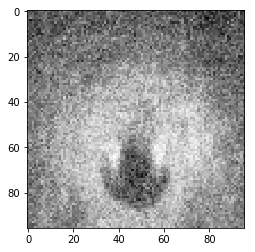

In [53]:
plt.imshow(amostras_teste[197].reshape(96,96), cmap = 'Greys')